In [165]:
"""
This program uses Long Short Term Memory to predict the closing stock price.
The prediction is based on the past 60 days stock price.
"""

'\nThis program uses Long Short Term Memory to predict the closing stock price.\nThe prediction is based on the past 60 days stock price.\n'

In [166]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

plt.style.use('fivethirtyeight')

In [167]:
# Get the stock quote
ticket = 'BTC-USD'
data_source ='yahoo'
period = 60
start = '2012-01-01'
days = 1

dte = datetime.now() - timedelta(days=1)
dtn = datetime.now()
end = dte.strftime('%Y-%m-%d')
now = dtn.strftime('%Y-%m-%d')

df = web.DataReader(ticket, data_source=data_source, start=start, end=end)
df.shape

(2433, 6)

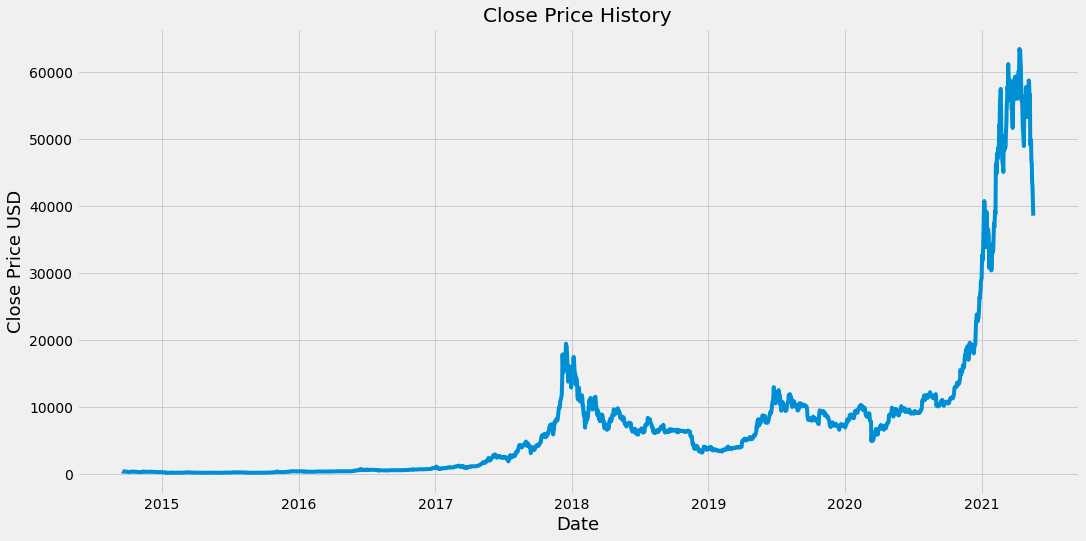

In [168]:
# Closing price history
plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.show()

In [169]:
# Filtering with Close Column
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len

1947

In [170]:
# Normalization
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00440947],
       [0.00389002],
       [0.0034219 ],
       ...,
       [0.68470851],
       [0.67478974],
       [0.60688731]])

In [171]:
# Creating Data set
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(period, len(train_data)):
  x_train.append(train_data[i-period:i, 0])
  y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((1887, 60), (1887,))

In [172]:
# Reshaping the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1887, 60, 1)

In [173]:
# Building the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [174]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
1887/1887 [==============================] - 50s 25ms/step - loss: 5.3741e-04
Epoch 2/10
1887/1887 [==============================] - 45s 24ms/step - loss: 1.3515e-04
Epoch 3/10
1887/1887 [==============================] - 45s 24ms/step - loss: 7.1167e-05
Epoch 4/10
1887/1887 [==============================] - 45s 24ms/step - loss: 6.0071e-05
Epoch 5/10
1887/1887 [==============================] - 45s 24ms/step - loss: 5.0336e-05
Epoch 6/10
1887/1887 [==============================] - 45s 24ms/step - loss: 5.0882e-05
Epoch 7/10
1887/1887 [==============================] - 45s 24ms/step - loss: 5.5428e-05
Epoch 8/10
1887/1887 [==============================] - 45s 24ms/step - loss: 4.7306e-05
Epoch 9/10
1887/1887 [==============================] - 45s 24ms/step - loss: 4.1196e-05
Epoch 10/10
1887/1887 [==============================] - 46s 24ms/step - loss: 4.7433e-05


In [175]:
# Testing Data Set
test_data = scaled_data[training_data_len - period: , :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(period, len(test_data)):
  x_test.append(test_data[i-period:i, 0])

x_test = np.array(x_test)

In [176]:
# Reshaping the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(486, 60, 1)

In [177]:
# Test the model
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [178]:
# RMSE
# rmse = np.sqrt(np.mean((predictions - y_test)**2))
# rmse = np.sqrt(np.mean(np.power((np.array(y_test) - np.array(predictions)), 2)))
rmse = np.sqrt(((predictions - y_test)**2).mean())
rmse

3871.5594791159365

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


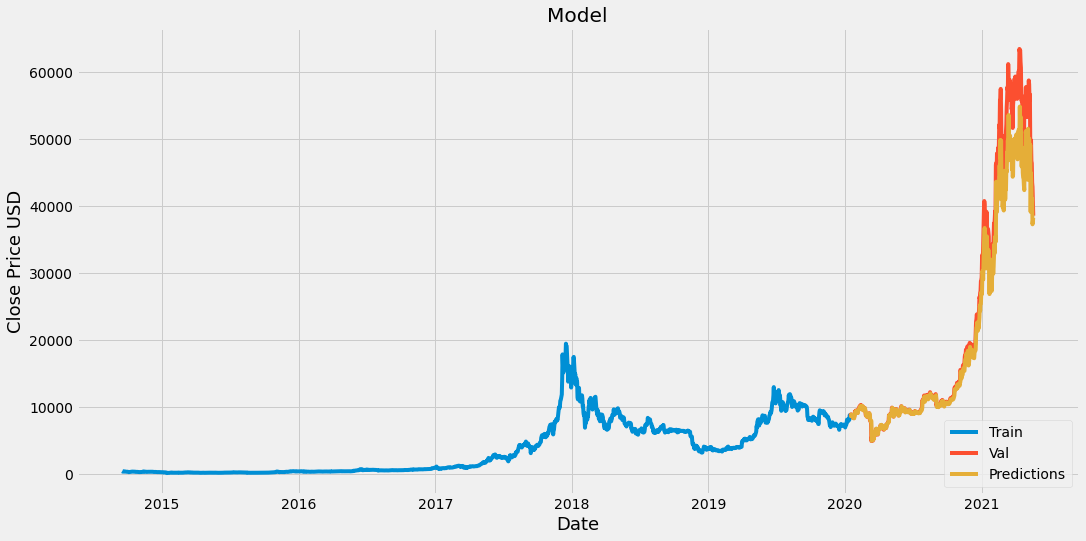

In [179]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [180]:
# Valid - Predicted
valid

,Close,Predictions
Date,,
2020-01-16,8723.786133,8769.597656
2020-01-17,8929.038086,8691.751953
2020-01-18,8942.808594,8915.780273
2020-01-19,8706.245117,8912.529297
2020-01-20,8657.642578,8671.041016
...,...,...
2021-05-14,46760.187500,43031.707031
2021-05-15,46456.058594,39790.496094
2021-05-16,43537.511719,41144.765625


In [181]:
# Predicted last know price
apple_quote = web.DataReader(ticket, data_source=data_source, start=start, end=now)
new_df = df.filter(['Close'])
last_60_days = new_df[-period:].values
last_60_days_scaled = scaler.fit_transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price[0][0]), 6)

print(f'Predicted price: ${pred_price}')

Predicted price: $38636.171875


In [182]:
apple_quote2 = web.DataReader(ticket, data_source=data_source, start=now, end=now)
real_price = apple_quote2['Close'].values

real_price = round(float(real_price[0]), 6)
print(f'Real price: ${real_price}')

Real price: $39693.9375


In [183]:
diff = (real_price - pred_price)
dffp = 100 * diff / real_price
print(f'Difference: ${round(diff,2)} {round(dffp,2)}%')

Difference: $1057.77 2.66%
